## Summary 

**Mar 19, 2021**

I spent a lot of time on this (> 4 hours) to really understand this. The mathematics was very easy to follow. This was the first time, I dug into the code. So I spent sufficient time understanding the details. 


**Main Points** 
* Illustrates Nadaraya-Watson Kernel Regression.
* Generates a toy dataset of 50 points. Scalar input and scalar output of a sine curve with gaussian noise.
* Illustrates how mean(y) fits the data.
* Then with a fixed (non-parametric) gaussian kernel, shows the fit to the data.
* Then trains a model which learns the best fit precision of the gaussian kernel and the fit is improved.


In [1]:
from d2l import torch as d2l
import torch
from torch import nn

* Generate data points from a sine function. 
* 50 points for training and 50 points equally spaced for test

In [2]:
n_train = 50  # No. of training examples
x_train, _ = torch.sort(torch.rand(n_train) * 5)   # Training inputs

def f(x):
    return 2 * torch.sin(x) + x**0.8

y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,))  # Training outputs
x_test = torch.arange(0, 5, 0.1)  # Testing examples
y_truth = f(x_test)  # Ground-truth outputs for the testing examples
n_test = len(x_test)  # No. of testing examples

In [3]:
def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'],
             xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5);

## Compare curve with mean(y)

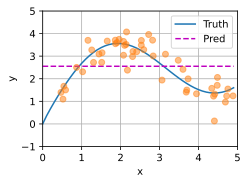

In [4]:
y_hat = y_train.mean().repeat(n_test)
plot_kernel_reg(y_hat)

## Non- Parametric gaussian kernel fit
Gaussian Kernel is used here with does not have any tuned parameters. So it gives significant weightage to points far away from x and therefore gives a bad fit.

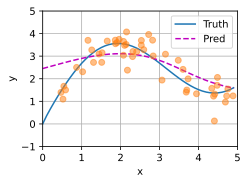

In [5]:
# Shape of `X_repeat`: (`n_test`, `n_train`), where each row contains the
# same testing inputs (i.e., same queries)
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))
# Note that `x_train` contains the keys. Shape of `attention_weights`:
# (`n_test`, `n_train`), where each row contains attention weights to be
# assigned among the values (`y_train`) given each query
attention_weights = nn.functional.softmax(-(X_repeat - x_train)**2/ 2, dim=1)
# Each element of `y_hat` is weighted average of values, where weights are
# attention weights
y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)

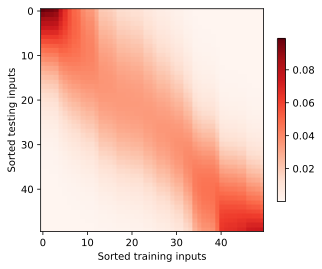

In [6]:
d2l.show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs', figsize=(5,5))

## Parametric Model

This model has just one scalar parameter "w" that is learned.

In [7]:
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand((1, ), requires_grad=True))

    def forward(self, queries, keys, values):
        # Shape of the output `queries` and `attention_weights`:
        # (no. of queries, no. of key-value pairs)
        queries = queries.repeat_interleave(keys.shape[1]).reshape(
            (-1, keys.shape[1]))
        self.attention_weights = nn.functional.softmax(
            -((queries - keys) * self.w)**2 / 2, dim=1)
        # Shape of `values`: (no. of queries, no. of key-value pairs)

        # The following is equivalent to  
        # torch.einsum("ij,ij->i", values, attention_weights)
        return torch.bmm(self.attention_weights.unsqueeze(1),
                         values.unsqueeze(-1)).reshape(-1)

In [8]:
# Shape of `X_tile`: (`n_train`, `n_train`), where each column contains the
# same training inputs
X_tile = x_train.repeat((n_train, 1))
# Shape of `Y_tile`: (`n_train`, `n_train`), where each column contains the
# same training outputs
Y_tile = y_train.repeat((n_train, 1))
# Shape of `keys`: ('n_train', 'n_train' - 1)
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
# Shape of `values`: ('n_train', 'n_train' - 1)
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape(
    (n_train, -1))


* $X_{tile}[i, :] = x_{train}$  (each side is row vector. of size n_train)
    * X_tile: (x_train) row vector stacked vertically n_train times

* $Y_{tile}[i, :] = y_{train} $ # (each side is row vector. of size n_train)
    * Y_tile: (y_train) row vector stacked vertically n_train times
* $keys[i, :] = x_{train}[1,2,...,i-1, i+1, ...]$
    * keys:  each row is x_train with one of x_i removed
* $values[i, :] = y_{train}[1,2,...,i-1, i+1, ...]$
    * similar setup to keys

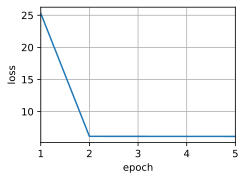

In [9]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)

animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])

for epoch in range(5):

    # Note: L2 Loss = 1/2 * MSE Loss. PyTorch has MSE Loss which is slightly
    # different from MXNet's L2Loss by a factor of 2. Hence we halve the loss
    l = loss(net(x_train, keys, values), y_train) / 2 

    trainer.zero_grad()
    l.sum().backward()
    
    trainer.step()
    print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')
    animator.add(epoch + 1, float(l.sum()))

The following figure shows how the kernel looks like with the learned weight parameter. It's more concentrated.

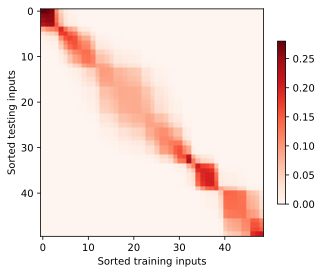

In [10]:
d2l.show_heatmaps(net.attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs', figsize=(5,5))

## Futher Understanding
Explore stuff in this exercise for better understanding

### Gaussian Kernel

In [13]:
import numpy as np
import matplotlib.pyplot as plt

In the following as you change $x_0$ the peak shifts. 
As you increase the value of $d$ the peak becomes more and more concentrated

$$
y=\exp\left\{ \dfrac{-\left(x-x_{0}\right)^{2}*d}{2}\right\} 
$$

This is related to gaussian distribution where $\sigma^{2}=1/d$, which is also known as precision. As the precision increases the distibution becomes more and more concentrated.


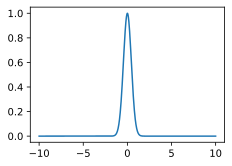

In [15]:
x0 = 0  # center
d = 5  # precision

x = np.linspace(-10.,10., 1000)
y = np.exp(-(x-x0)**2*d/2)
plt.plot(x,y)